In [3]:
import json
import pytz

import datetime as dt
import numpy as np
import pandas as pd

from voltoolbox.fit.option_quotes import OptionSnapshot
from voltoolbox.fit.forward_fit import fit_forward_curve
from voltoolbox.fit.fit_utils import prepare_vol_quotes, act365_time
from voltoolbox.fit.vol_fit import TargetSlice, fit_atm_vol
from voltoolbox.calendar import nyse_calendar
from voltoolbox import BusinessTimeMeasure

file = 'vol_SPX_20210527_1857.json'
with open(file, 'r') as f:
    quotes_dict = json.loads(f.read())

quotes = OptionSnapshot.from_json_dict(quotes_dict)

pricing_dt = quotes.time_stamp
if pricing_dt.tzinfo is None:
    pricing_dt = pytz.UTC.localize(pricing_dt)  

BOX_SPREAD = 50.0 / 10000.0 #50bp
forward_curve =  fit_forward_curve(quotes, BOX_SPREAD)

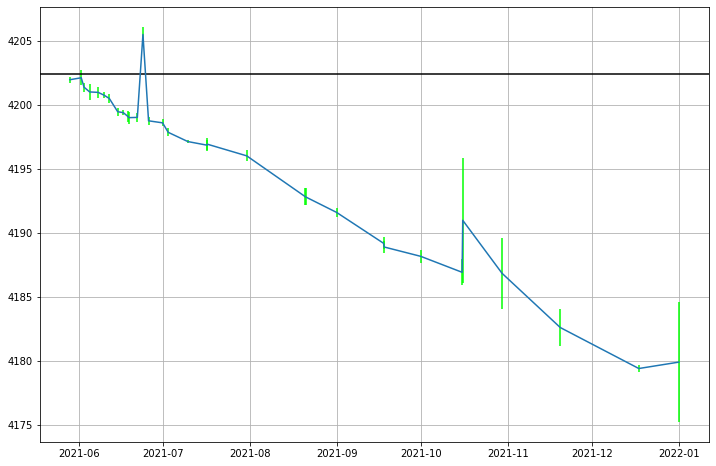

In [5]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([6.0, 4.0]) * 2.0

forward_crv_datas = []
for expiry, fwd_quote in forward_curve.items():
    fwd_bid, fwd_ask = fwd_quote
    fwd = 0.5 * (fwd_bid + fwd_ask)
    forward_crv_datas.append([expiry, fwd, fwd_bid, fwd_ask])
forward_crv_df = pd.DataFrame(data=forward_crv_datas,
                              columns=['expiry', 'fwd', 'fwd_bid', 'fwd_ask'] )
forward_crv_df.set_index('expiry', inplace=True)
forward_crv_df.index = pd.DatetimeIndex(forward_crv_df.index)

disp_fwd_crv_df = forward_crv_df[forward_crv_df.index < '2022-01-01']
plt.errorbar(disp_fwd_crv_df.fwd.index, disp_fwd_crv_df.fwd.values,
             yerr= (disp_fwd_crv_df.fwd_ask - disp_fwd_crv_df.fwd_bid).values, 
             ecolor='lime')
plt.axhline(y=quotes.ref_spot, color='black')
plt.grid()
plt.show()

In [6]:
quote_slices = {quot_sl.expiry : quot_sl for quot_sl in quotes.slices}
expi_w = widgets.SelectionSlider(options = quote_slices.keys())
@widgets.interact(expi_dt=expi_w)
def plot_callput_parity(expi_dt):
    opt_sl = quote_slices[expi_dt]

    time_to_mat = act365_time(pricing_dt, opt_sl.expiry)
    discount = opt_sl.discount
    discount *= np.exp(- BOX_SPREAD * time_to_mat)

    call = opt_sl.call
    call_asks = pd.Series(call.asks, call.strikes)
    call_bids = pd.Series(call.bids, call.strikes)

    put = opt_sl.put
    put_asks = pd.Series(put.asks, put.strikes)
    put_bids = pd.Series(put.bids, put.strikes)
    
    fwd_asks = (call_asks - put_bids) / discount
    fwd_asks += fwd_asks.index
    fwd_asks = fwd_asks.dropna()
    
    fwd_bids = (call_bids - put_asks) / discount
    fwd_bids += fwd_bids.index 
    fwd_bids = fwd_bids.dropna()
   
    fwd_quote = forward_crv_df.loc[opt_sl.expiry]
    fitted_fwd, fwd_bid, fwd_ask = fwd_quote.fwd, fwd_quote.fwd_bid, fwd_quote.fwd_ask

    plt.plot(fwd_asks, marker='+', linestyle='none')
    plt.plot(fwd_bids, marker='+', linestyle='none')
    #plt.axhline(y=quotes.ref_spot, color='black')
    
    plt.axhline(y=fwd_ask, color='blue')
    plt.axhline(y=fwd_bid, color='red')
    plt.axhline(y=fitted_fwd, color='lime')

    DISPLAY_NB_SPREAD = 5
    plt.ylim((fwd_bid - DISPLAY_NB_SPREAD * (fwd_ask - fwd_bid), fwd_ask + DISPLAY_NB_SPREAD * (fwd_ask - fwd_bid)))

    plt.title(f'{expi_dt}    ')
    plt.grid()
    plt.show()

interactive(children=(SelectionSlider(description='expi_dt', options=(datetime.datetime(2021, 5, 28, 19, 56, t…